In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

# Set the path to the dataset directory
dataset_path = r'C:\Users\ADMIN\Downloads\Ann\Dataset\kaggle_3m'

In [2]:
# Define a function to determine the class label from the file path
def get_label(file_path):
    return 1 if "1." in file_path else 0

# Get the list of all image paths in the dataset
all_image_paths = glob(os.path.join(dataset_path, '**', '*.tif'), recursive=True)

# Separate paths for masks and images
mask_files = [path for path in all_image_paths if "_mask" in path]
image_files = [path for path in all_image_paths if "_mask" not in path]

# Extract labels for each image file
image_labels = [get_label(path) for path in image_files]

# Split the data into training, validation, and test sets
train_img_files, test_img_files, train_img_labels, test_img_labels = train_test_split(
    image_files, image_labels, test_size=0.15, random_state=42)
train_img_files, val_img_files, train_img_labels, val_img_labels = train_test_split(
    train_img_files, train_img_labels, test_size=0.1, random_state=42)


In [3]:
# Function to load and preprocess images
def preprocess_img(file_path, target_size=(256, 256)):
    image = Image.open(file_path)
    image = image.resize(target_size)
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load and preprocess the images
train_images = np.array([preprocess_img(path) for path in train_img_files])
val_images = np.array([preprocess_img(path) for path in val_img_files])
test_images = np.array([preprocess_img(path) for path in test_img_files])

# Reshape the images to 1D arrays
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [4]:
# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_images_flat, train_img_labels)

# Predict on the test set
test_predictions = rf_model.predict(test_images_flat)

In [5]:

# Calculate accuracy, confusion matrix, and classification report
test_accuracy = accuracy_score(test_img_labels, test_predictions)
test_conf_matrix = confusion_matrix(test_img_labels, test_predictions)
test_class_report = classification_report(test_img_labels, test_predictions, target_names=["Negative", "Positive"])

print("Random Forest Test Accuracy:", test_accuracy)
print("Random Forest Confusion Matrix:\n", test_conf_matrix)
print("Random Forest Classification Report:\n", test_class_report)



Random Forest Test Accuracy: 0.8966101694915254
Random Forest Confusion Matrix:
 [[521   4]
 [ 57   8]]
Random Forest Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.99      0.94       525
    Positive       0.67      0.12      0.21        65

    accuracy                           0.90       590
   macro avg       0.78      0.56      0.58       590
weighted avg       0.88      0.90      0.86       590



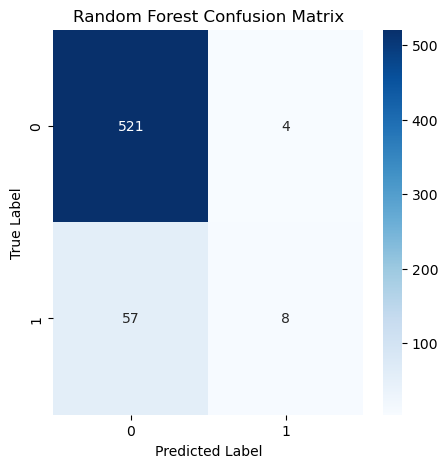

In [6]:

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


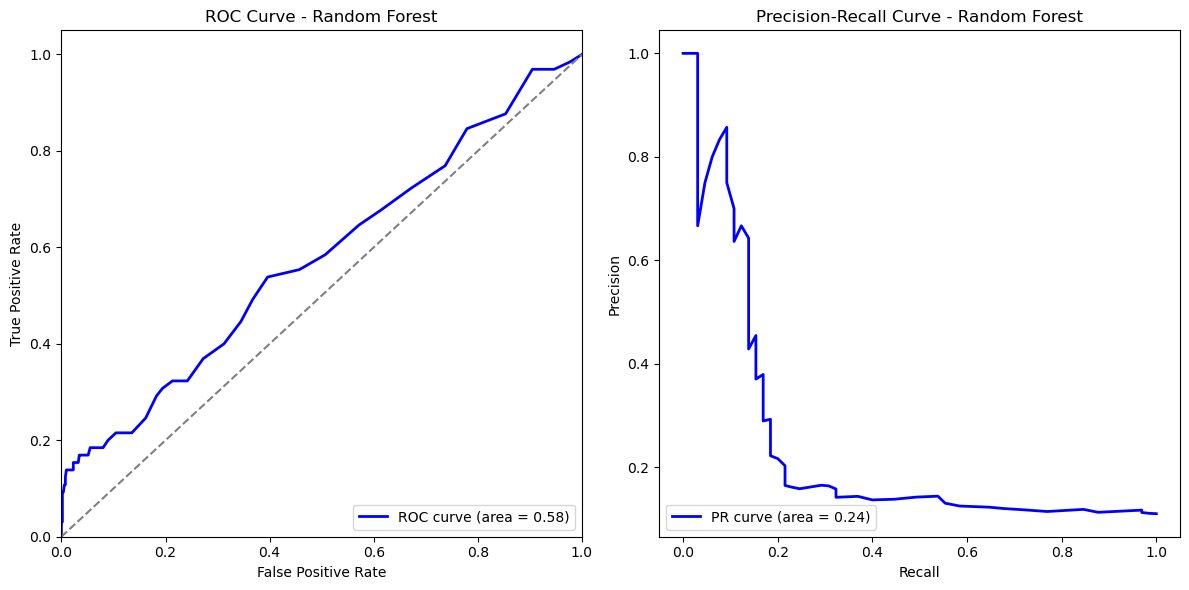

In [7]:


from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Calculate probabilities and performance metrics
test_probabilities = rf_model.predict_proba(test_images_flat)[:, 1]
fpr, tpr, _ = roc_curve(test_img_labels, test_probabilities)
roc_auc = roc_auc_score(test_img_labels, test_probabilities)
precision, recall, _ = precision_recall_curve(test_img_labels, test_probabilities)
pr_auc = auc(recall, precision)

# Plot ROC and Precision-Recall curves
plt.figure(figsize=(12, 6))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()
